In [1]:
import polars as pl
import polars.selectors as cs
import gzip
import requests
import optuna
import io


In [2]:
"""
from sklearnex import patch_sklearn
import logging
logger = logging.getLogger('sklearnex')
logger.setLevel(logging.WARNING)
patch_sklearn()
"""

"\nfrom sklearnex import patch_sklearn\nimport logging\nlogger = logging.getLogger('sklearnex')\nlogger.setLevel(logging.WARNING)\npatch_sklearn()\n"

# Motivation
Airbnb is a platform in which essentially anyone is able to rent out spare space in their homes. In a consistently evolving market, remaining competitive in pricing can be difficult for the average user. As such creating a model that is able to predict costs accurate may result in the maximization of an individuals potential income by remaining competitive. By using freely available data, one could automate this task and set pricing automatically based on factors relating to their home and current market trends. The prediction of a continous value is a regression problem. Notably this pipeline could be extended to much more data as there is more data on the website, however for the sake of time and computational power I have limited it here to just boston. Due to many features, with enough data collection this could potentially be a good test case for a deep learning model in fact. Additionally knowing what results in higher prices, may allow those posting on the site to add these things to their own listings to increase value. The value to be predicted here is the daily price charge for airbnb listings.

# Preprocessing
Because this data is both quite messy and also contains a plethora of data for potential analysis preprocessing needs to be performed before making an accurate assessment of the underlying data itself.This data is fetched from insideairbnb which scrapes airbnb listings.

In [3]:
# Hardcode the compressed files to be used for this analysis these links could be scraped off the page if more data was required
listing_urls = [
    "https://data.insideairbnb.com/united-states/ma/boston/2025-03-15/data/listings.csv.gz",
    "https://data.insideairbnb.com/united-states/ma/boston/2024-12-20/data/listings.csv.gz",
    "https://data.insideairbnb.com/united-states/ma/boston/2024-09-18/data/listings.csv.gz",
    "https://data.insideairbnb.com/united-states/ma/boston/2024-06-22/data/listings.csv.gz"
]

In [4]:
# Fetch the data from insideairbnb, create a list for each dataframe, them concatenate them all together
# Diagonal allows there to be inconsistent column names
def concatenate_data(urls:list) -> pl.DataFrame:
    dfs = []    
    for url in urls:
        print(f"Downloading: {url}")
        response = requests.get(url)
        response.raise_for_status()

        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
            df = pl.read_csv(f)
            dfs.append(df)
    combined = pl.concat(dfs, how="diagonal")
    return combined


listings = concatenate_data(listing_urls)

Downloading: https://data.insideairbnb.com/united-states/ma/boston/2025-03-15/data/listings.csv.gz
Downloading: https://data.insideairbnb.com/united-states/ma/boston/2024-12-20/data/listings.csv.gz
Downloading: https://data.insideairbnb.com/united-states/ma/boston/2024-09-18/data/listings.csv.gz
Downloading: https://data.insideairbnb.com/united-states/ma/boston/2024-06-22/data/listings.csv.gz


In [5]:
# Drop Unneeded Columns
# Although potentially useful, too many features for kaggles lowly cpu power
# Also many redundant features
drop = [
    'listing_url',
    'scrape_id',
    'source',
    'picture_url',
    'host_id',
    'host_url',
    'host_name',
    'host_thumbnail_url',
    'host_picture_url',
    'neighbourhood',
    'neighbourhood_group_cleansed',
    'bathrooms_text',
    'calendar_updated',
    'calendar_last_scraped',
    'review_scores_cleanliness',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'license',
    'host_verifications',
    'amenities', # So this is likely a useful column however since there is basically an infinite amount of combinations not doing this for kaggle, will probably use this for my own personal portfolio however
    'first_review',
    'last_review'
]
listings_red = listings.drop(drop)
# Since we are prediciting price (Per Night) we can't have nulls
listings_red = listings_red.filter(pl.col("price").is_not_null())

In [6]:
# Get a general sense of the data
listings_red.describe()

statistic,id,last_scraped,name,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_checkin,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,f64,f64,str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",14394.0,"""14394""","""14394""","""14139""","""8627""","""14394""","""11420""","""14394""","""14394""","""14394""","""14394""","""13684""","""14156""",14394.0,14394.0,"""14394""","""14394""","""14394""",14394.0,14394.0,"""14394""","""14394""",14394.0,14394.0,14394.0,14321.0,"""14394""",14394.0,14394.0,14394.0,14394.0,14394.0,14394.0,14394.0,14394.0,"""14286""",14394.0,14394.0,14394.0,14394.0,14394.0,14394.0,14394.0,3643.0,3643.0,3643.0,3643.0,11183.0,11175.0,11172.0,"""14394""",14394.0,14394.0,14394.0,14394.0,11183.0
"""null_count""",0.0,"""0""","""0""","""255""","""5767""","""0""","""2974""","""0""","""0""","""0""","""0""","""710""","""238""",0.0,0.0,"""0""","""0""","""0""",0.0,0.0,"""0""","""0""",0.0,0.0,0.0,73.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""108""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,10751.0,10751.0,10751.0,10751.0,3211.0,3219.0,3222.0,"""0""",0.0,0.0,0.0,0.0,3211.0
"""mean""",5.7492e17,null,null,null,null,null,null,null,null,null,null,null,null,513.429137,631.42344,null,null,null,42.336903,-71.082271,null,null,3.280186,1.242775,1.437057,1.825641,null,21.73878,549.732736,20.663332,51.039183,1.4926e6,5.8192e6,22.719446,3.4803e6,null,12.512992,29.746075,50.024038,223.848895,54.093859,14.239614,0.974712,179.848477,14.155092,94.146857,17248.791106,4.728003,4.773264,4.836794,null,58.299639,50.466792,7.427817,0.007573,1.966001
"""std""",5.0515e17,null,null,null,null,null,null,null,null,null,null,null,null,1385.141848,1536.383816,null,null,null,0.027067,0.03199,null,null,2.373383,0.59104,1.148753,1.538555,null,29.228722,412.290613,28.41392,97.279105,5.6585e7,1.1163e8,29.28356,7.5659e7,null,11.01729,21.232284,30.485852,109.248141,100.909914,22.751987,2.010581,88.5405,23.942094,101.491773,26071.644009,0.402128,0.362888,0.378163,null,104.537569,104.741613,25.046333,0.104167,2.098252
"""min""",3781.0,"""2024-06-22""","""""Casita"" on the Water - Harbor…","""""Discover comfort and convenie…","""""Affluent Back Bay is a shoppi…","""2008-12-03""","""Acton, MA""","""""","""N/A""","""0%""","""0%""","""f""","""Allapattah""",1.0,1.0,"""f""","""f""","""Allston""",42.2353,-71.17402,"""Boat""","""Entire home/apt""",1.0,0.0,0.0,0.0,"""$1,000.00""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""t""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"""f""",1.0,0.0,0.0,0.0,0.01
"""25%""",4.1708678e7,null,null,null,null,null,null,null,null,null,null,null,null,3.0,4.0,null,null,null,42.32212,-71.096313,null,null,2.0,1.0,1.0,1.0,null,1.0,365.0,1.0,3.0,365.0,365.0,2.0,365.0,null,1.0,11.0,24.0,137.0,1.0,0.0,0.0,116.0,0.0,0.0,0.0,4.67,4.71,4.83,null,2.0,1.0,0.0,0.0,0.37
"""50%""",6.9985e17,null,null,null,null,null,null,null,null,null,null,null,null,17.0,24.0,null,null,null,42.3

In [7]:
# Label column types for later operations

# These columns are text based and will receive tfidf
text_cols = [
    'name',
    'description',
    'neighborhood_overview',
    'host_about'
]

# Categorical columns to be one hot encoded
text_cols_cat = [
    'host_location',
    'host_response_time',
    'host_neighbourhood',
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]

# These columns are converted to binary values
bool_cols = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]

# The rest of the columns are numeric

In [8]:
# Convert any "boolean" columns to binary encoding
for col in bool_cols:
    listings_red = listings_red.with_columns(
        pl.when(pl.col(col) == "t")
        .then(1)
        .otherwise(0)
        .alias(col)
    )

In [9]:
# Convert rows with percentages to 
import re
def percentage_to_decimal(text):
    if text:
        try:
            clean_text = re.sub("[^[0-9]", "", text)
            val = int(clean_text) / 100
            return val
        except:
            return None
    else:
        return None

# Apply the function
listings_red = listings_red.with_columns([
    pl.col("host_acceptance_rate").map_elements(percentage_to_decimal, return_dtype=pl.Float64).alias("host_acceptance_rate"),
    pl.col("host_response_rate").map_elements(percentage_to_decimal, return_dtype=pl.Float64).alias("host_response_rate")
])

In [10]:
# Get rid of dollar sings
listings_red = listings_red.with_columns(pl.col("price").str.replace(r"\$", ""))

In [11]:
# Derive the length the listing has existed
listings_red = listings_red.with_columns(
    pl.col("host_since").str.strptime(pl.Date, "%Y-%m-%d").alias("start_date_dt"),
    pl.col("last_scraped").str.strptime(pl.Date, "%Y-%m-%d").alias("end_date_dt"),
).with_columns(
    (pl.col("end_date_dt") - pl.col("start_date_dt")).alias("listing_age").dt.total_days()
).drop(["host_since", "last_scraped","start_date_dt","end_date_dt"])

In [12]:
# Now we can split the data to avoid any leakage
from sklearn.model_selection import train_test_split

X = listings_red.drop(['price', 'id'])
y = listings_red.select('price')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 66
)

In [13]:
# One hot encode our categorical columns
X_train_clean = X_train.to_dummies(
    drop_first = True,
    columns = text_cols_cat
)
X_test_clean = X_test.to_dummies(
    drop_first = True,
    columns = text_cols_cat
)

In [14]:
train_columns = X_train_clean.columns
test_columns = X_test_clean.columns

In [15]:
# Make sure our columns are the same and fill any missing columns with 0
missing_columns_test = set(train_columns) - set(test_columns)
missing_columns_train = set(test_columns) - set(train_columns)

for col in missing_columns_train:
    X_train_clean = X_train_clean.with_columns(pl.lit(0).alias(col))

for col in missing_columns_test:
    X_test_clean = X_test_clean.with_columns(pl.lit(0).alias(col))

In [16]:
# Fix any column order issues and then throw error if not
column_order = sorted(X_train_clean.columns)
X_train_clean = X_train_clean.select(column_order)
X_test_clean = X_test_clean.select(column_order)

assert X_train_clean.columns == X_test_clean.columns

In [17]:
# Do imputation for missing data using RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

numeric = X_train_clean.select(cs.numeric()).columns

non_numeric = X_train_clean.select(~cs.numeric()).columns

imp = IterativeImputer(estimator = RandomForestRegressor(random_state=66, n_jobs=-1))
imp.fit(X_train_clean[numeric])
X_train_imputed = imp.transform(X_train_clean[numeric])
X_test_imputed = imp.transform(X_test_clean[numeric])

In [18]:
# After pulling out only the columns that need to be imputed convert them back to dataframes
X_train_imputed_numeric = pl.DataFrame(X_train_imputed, schema=numeric)
X_test_imputed_numeric = pl.DataFrame(X_test_imputed, schema=numeric)

In [19]:
# Combine the imputed values with the text columns
X_train_fin = pl.concat([X_train_clean[non_numeric],X_train_imputed_numeric], how='horizontal')
X_test_fin = pl.concat([X_test_clean[non_numeric],X_test_imputed_numeric], how='horizontal')

In [20]:
# Automate the removal of outliers using IsolationForest
from sklearn.ensemble import IsolationForest
X_train_temp = X_train_fin.drop(~cs.numeric())
iso_forest = IsolationForest(n_jobs=-1)
mask_np = iso_forest.fit_predict(X_train_temp) != -1
mask = pl.Series(mask_np)
X_train_fin, y_train_fin = X_train_fin.filter(mask), y_train.filter(mask)

In [21]:
# Make sure any missing text in our text columns is filled as blank to avoid errors
X_train_fin = X_train_fin.with_columns([
    pl.col(col).fill_null("") for col in text_cols
])

X_test_fin = X_test_fin.with_columns([
    pl.col(col).fill_null("") for col in text_cols
])

In [22]:
# Make sure these columns are actual floats and not strings
y_train_fin = (
    y_train_fin
    .with_columns(
        pl.col("price").str.replace(",","").cast(pl.Float64)
    )
)
y_test = (
    y_test
    .with_columns(
        pl.col("price").str.replace(",","").cast(pl.Float64)
    )
)

# Descriptives (basic)
Of course these descriptive will only apply to the training set since we don't technically know the distribution of the test data. Fortunately I have intentionally ignored it's existence here almost entirely in the code.

Text(0, 0.5, 'Count')

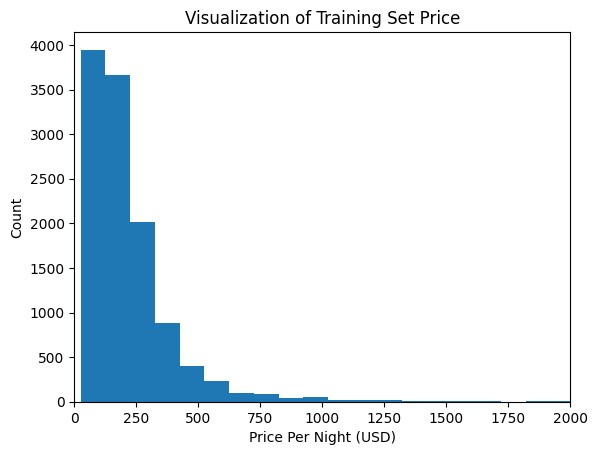

In [23]:
import matplotlib.pyplot as plt
plt.hist(y_train_fin, bins=100)
plt.xlim(0, 2000)
plt.title('Visualization of Training Set Price')
plt.xlabel('Price Per Night (USD)')
plt.ylabel('Count')
# Notably very skewed to the right since I am using regression likely a transformation would be helpful
# Additionally if we wanted to interpret the data we could afterwards wtih inverse_transform

In [24]:
#Use box-cox transform
from sklearn.preprocessing import PowerTransformer
normalizer = PowerTransformer(method='box-cox', standardize=False)
normalizer.fit(y_train_fin)
y_train_fin = pl.DataFrame(normalizer.transform(y_train_fin), schema = ['price'])
y_test = pl.DataFrame(normalizer.transform(y_test), schema = ['price'])

Text(0, 0.5, 'Count')

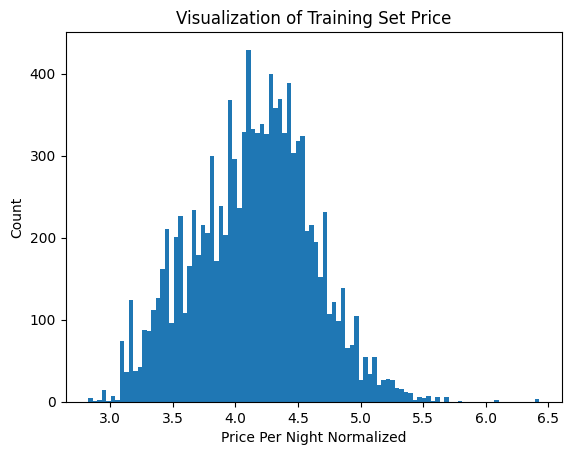

In [25]:
plt.hist(y_train_fin, bins=100)
plt.title('Visualization of Training Set Price')
plt.xlabel('Price Per Night Normalized')
plt.ylabel('Count')

In [26]:
# What does our actual data look like?

# This is of course before we vectorize our text so it's probably a bit more than this
print(f"Number of Columns {X_train_fin.width}")
print(f"Number of Training Rows {X_train_fin.height}")
# Unfortunately we've got a very small test size but again ties into not wanting the models to run forever giving the number of features
print(f"Number of Test Rows {X_test_fin.height}")

Number of Columns 371
Number of Training Rows 11515
Number of Test Rows 2879


In [27]:
# No nulls
null_counts = X_train_fin.null_count()
cols_with_nulls = [col for col in null_counts.columns if null_counts[0, col] > 0]

print("Columns with nulls:", cols_with_nulls)

null_counts = X_test_fin.null_count()
cols_with_nulls = [col for col in null_counts.columns if null_counts[0, col] > 0]

print("Columns with nulls:", cols_with_nulls)

Columns with nulls: []
Columns with nulls: []


In [28]:
from sklearn.metrics import mean_squared_error
# Older versions of sklearn do not play nicely with polars dataframes (Kaggle)
#X_train_fin = X_train_fin.to_pandas()
#X_test_fin = X_test_fin.to_pandas()
#y_train_fin = y_train_fin.to_pandas()
#y_train = y_train.to_pandas()

# Model Fitting
I had originally elected to use Log RSME since the price values are heavily skewed. This however poses a problem: some models (Name XGBoost) predict negative values. This makes the formula invalid. So instead I'll use RSME. This should at least be somewhat robust to outliers and avoid the issue with error. We want a good model that generalizes well not one that optimizes for purely high prices in this case.

In [29]:
# Model fitting time
# I've used optuna because it doesn't take nearly as much time as gridsearch since it isn't exhausting
# It also optimizes much better than say halving grid search or whatever else scikit has
# I also prefer the syntax
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Since I believe the text to be useful but also unrelated to the other text for the purposes of processing
# I apply tfidf to each column. 
# Certainly this step could be optimized
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(stop_words='english'), 'name'),
        ('description_tfidf', TfidfVectorizer(stop_words='english'), 'description'),
        ('neighborhood_tfidf', TfidfVectorizer(stop_words='english'), 'neighborhood_overview'),
        ('host_tfidf', TfidfVectorizer(stop_words='english'), 'host_about')
    ]
)

# KNeighborsRegressor Optimizer
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    model = KNeighborsRegressor(n_neighbors=n_neighbors)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    score = cross_val_score(pipeline, X_train_fin, y_train_fin, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()
    
# XGBRegressor Optimizer
def objective_xgb(trial):
    reg_lambda = trial.suggest_float('lambda', 1e-4, 1e2)
    reg_alpha = trial.suggest_float('alpha', 0.0, 1.0)
    model = XGBRegressor(reg_lambda=reg_lambda, reg_alpha=reg_alpha, random_state=66)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    score = cross_val_score(pipeline, X_train_fin, y_train_fin, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

# ElasticNet Optimizer
def objective_enet(trial):
    alpha = trial.suggest_float('alpha', 1e-4, 1e2)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=66)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    score = cross_val_score(pipeline, X_train_fin, y_train_fin, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

#I used 30 trials on my laptop but for the submission using less since it takes too long
def optimize_model(objective_func, model_name, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_func, n_trials=n_trials)
    best_params = study.best_params
    print(f"Best params for {model_name}: {best_params} /n Best Score: {study.best_value}")
    return best_params
    

In [30]:
best_knn_params = optimize_model(objective_knn, 'KNeighborsRegressor')

[I 2025-05-28 16:06:31,978] A new study created in memory with name: no-name-4d028f4e-cd85-4e69-b186-b847d6193dc8
[I 2025-05-28 16:06:36,276] Trial 0 finished with value: 0.27808642783763393 and parameters: {'n_neighbors': 8}. Best is trial 0 with value: 0.27808642783763393.
[I 2025-05-28 16:06:39,248] Trial 1 finished with value: 0.34997586947750126 and parameters: {'n_neighbors': 39}. Best is trial 0 with value: 0.27808642783763393.
[I 2025-05-28 16:06:42,680] Trial 2 finished with value: 0.262373945667394 and parameters: {'n_neighbors': 5}. Best is trial 2 with value: 0.262373945667394.
[I 2025-05-28 16:06:45,307] Trial 3 finished with value: 0.34825205174559876 and parameters: {'n_neighbors': 35}. Best is trial 2 with value: 0.262373945667394.
[I 2025-05-28 16:06:48,380] Trial 4 finished with value: 0.2935619520101235 and parameters: {'n_neighbors': 12}. Best is trial 2 with value: 0.262373945667394.
[I 2025-05-28 16:06:50,778] Trial 5 finished with value: 0.2935619520101235 and pa

Best params for KNeighborsRegressor: {'n_neighbors': 2} /n Best Score: 0.24592212184431


In [31]:
best_xgb_params = optimize_model(objective_xgb, 'XGBRegressor')

[I 2025-05-28 16:07:21,929] A new study created in memory with name: no-name-602f2516-4c8b-46b4-8bc4-479351ced6b1
[I 2025-05-28 16:07:32,669] Trial 0 finished with value: 0.2428620934486389 and parameters: {'lambda': 76.41824686245812, 'alpha': 0.405350254650091}. Best is trial 0 with value: 0.2428620934486389.
[I 2025-05-28 16:07:42,444] Trial 1 finished with value: 0.23584794402122497 and parameters: {'lambda': 14.952421255517637, 'alpha': 0.6451194203126531}. Best is trial 1 with value: 0.23584794402122497.
[I 2025-05-28 16:07:52,752] Trial 2 finished with value: 0.24306821823120117 and parameters: {'lambda': 93.12180749356448, 'alpha': 0.03693980941955388}. Best is trial 1 with value: 0.23584794402122497.
[I 2025-05-28 16:08:03,009] Trial 3 finished with value: 0.24302232265472412 and parameters: {'lambda': 74.20739894552966, 'alpha': 0.8179160286219382}. Best is trial 1 with value: 0.23584794402122497.
[I 2025-05-28 16:08:13,486] Trial 4 finished with value: 0.24229182302951813 an

Best params for XGBRegressor: {'lambda': 0.07068069290204779, 'alpha': 0.6216621628657075} /n Best Score: 0.224894180893898


In [32]:
best_enet_params = optimize_model(objective_enet, 'ElasticNet')

[I 2025-05-28 16:10:41,681] A new study created in memory with name: no-name-130bae51-3b09-4f9e-9de2-ea1c05c67f6d
[I 2025-05-28 16:10:43,384] Trial 0 finished with value: 0.47241931678371074 and parameters: {'alpha': 98.71719091044865, 'l1_ratio': 0.18971073784643555}. Best is trial 0 with value: 0.47241931678371074.
[I 2025-05-28 16:10:45,102] Trial 1 finished with value: 0.47241931678371074 and parameters: {'alpha': 2.3089885594234376, 'l1_ratio': 0.6265293477472876}. Best is trial 0 with value: 0.47241931678371074.
[I 2025-05-28 16:10:46,816] Trial 2 finished with value: 0.47241931678371074 and parameters: {'alpha': 13.51015025990741, 'l1_ratio': 0.6242150263765683}. Best is trial 0 with value: 0.47241931678371074.
[I 2025-05-28 16:10:48,480] Trial 3 finished with value: 0.47241931678371074 and parameters: {'alpha': 49.51518289976635, 'l1_ratio': 0.33803606150114873}. Best is trial 0 with value: 0.47241931678371074.
[I 2025-05-28 16:10:50,205] Trial 4 finished with value: 0.47241931

Best params for ElasticNet: {'alpha': 98.71719091044865, 'l1_ratio': 0.18971073784643555} /n Best Score: 0.47241931678371074


# Evaluation

In [33]:
# Well even with some normalization regression performs quite poorly. 
# Xgboost and Knn are actually quite close which is impressive.
# Since I've used cross validation unsurprisingly the models fit pretty similarly to the training sets which is very good
# XGB actually fits better to the test data which is quite interesting. 
from sklearn.metrics import root_mean_squared_error
models = {
    'knn': KNeighborsRegressor(n_neighbors=best_knn_params['n_neighbors']),
    'xgb': XGBRegressor(reg_lambda=best_xgb_params['lambda'], 
                        reg_alpha=best_xgb_params['alpha'], 
                        random_state=66),
    'enet': ElasticNet(alpha=best_enet_params['alpha'], 
                       l1_ratio=best_enet_params['l1_ratio'], 
                       random_state=66)
}

test_scores = {}


for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train_fin, y_train_fin)
    y_pred = pipeline.predict(X_test_fin)
    rsme = root_mean_squared_error(y_test,y_pred)
    test_scores[name] = rsme


print("\nTest RSME scores:")
for name, score in test_scores.items():
    print(f"{name}: {score:.4f}")


Test RSME scores:
knn: 0.2336
xgb: 0.2218
enet: 0.4755


These results are fairly unsurprising. Regression is quite inflexible and often tends to be outperformed on data that isn't very linear. Also considering how many features there are it makes sense regression does not do that well here. KNN and XGB both are much more flexible at the cost of potentially overfitting although in this case they did not. Notably XGB did predict some negative values, and also KNN chose one of the lowest values of neighbors as the best model likely as the resulted in the least overfitting. Since we are essentially doing regression all the outputs of the models here are quite interpretable. We would just need to reverse the box-cox operation to actually understand the values generated as predictions.